In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras import models, layers, utils, backend as K
import shap
from tensorflow.keras.utils import plot_model


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # viz
import matplotlib.pyplot as plt # viz
from scipy import stats
import json
from typing import List, Tuple

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn import metrics, linear_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [2]:
#datos = pd.read_csv("labelled_training_data_2.csv")
train_df = pd.read_excel("labelled_training_data_2.xlsx")
train_df.head()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


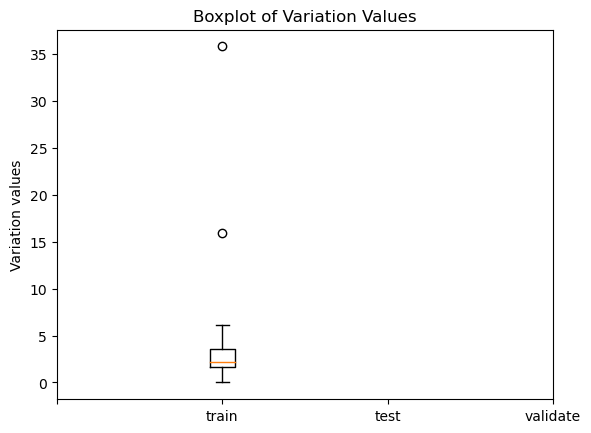

In [3]:
datasets = [train_df]

variation_values = []
for dataset in datasets:
    dataset_variation_values = []
    for col in dataset.columns:
        if col == 'timestamp':
            pass
        else:
            counts = dataset[col].value_counts()
            col_variation = stats.variation(counts)
            dataset_variation_values.append(col_variation)
            
    variation_values.append(dataset_variation_values)

plt.boxplot(variation_values)
plt.title('Boxplot of Variation Values')
plt.ylabel("Variation values")
plt.xticks([0,1,2,3],labels=['','train', 'test', 'validate'])
plt.show()

In [4]:
train_data = pd.DataFrame(train_df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])
train_labels = pd.DataFrame(train_df[["sus"]])

In [5]:
data_tensor = torch.as_tensor(train_data.values, dtype=torch.int32)
label_tensor = torch.as_tensor(train_labels.values, dtype=torch.int32)

In [6]:
train_dataset = TensorDataset(data_tensor, label_tensor)

In [7]:
train_data_ldr = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [8]:
for i, (x, y) in enumerate(train_data_ldr):
    if i == 1:
        break
    else:
        print(f'Index: {i} \n Data Tensor: {x} \n Label Tensor: {y}')

Index: 0 
 Data Tensor: tensor([[      7296,       1317,          0, -268435456,       1005,          4,
                  0],
        [      7295,       1317,          0, -268435456,          4,          2,
                  0],
        [      7276,       1317,          0, -268435456,          3,          1,
                  0],
        [      7278,       1317,          0, -268435456,        257,          4,
                 -2],
        [      7257,          1,          0, -268435456,          4,          2,
                 -2],
        [       812,          1,       1000, -268435456,       1005,          4,
                  0],
        [      7294,       1317,          0, -268435456,        257,          4,
                  9],
        [         1,          0,          0, -268435456,          3,          1,
                  0],
        [      7282,       1317,          0, -268435456,        257,          4,
                  9],
        [       159,          1,          0, -268

In [9]:
def prepare_tensor_dataset(df: pd.DataFrame, feature_cols: List, label_col: str) -> Tuple[TensorDataset, DataLoader]:
    """
    Converts an inpurt Pandas DataFrame to a Tensor Dataset and Data Loader.
    """
    if all([col in df.columns for item in feature_cols]) and label_col in df.columns:
        
        labels = pd.DataFrame(df[[label_col]])
        features = pd.DataFrame(df[feature_cols])

        data_tensor = torch.as_tensor(features.values, dtype=torch.int32)
        label_tensor = torch.as_tensor(train_labels.values, dtype=torch.int32)
        
        tensor_dataset = TensorDataset(data_tensor, label_tensor)
        
        data_ldr = train_data_ldr = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        return tensor_dataset, data_ldr
    else:
        raise ValueError('Unable to find all columns')

In [10]:
label_col = 'sus'
feat_cols = ["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]

train_tensor_dataset, train_data_ldr = prepare_tensor_dataset(train_df, feat_cols, label_col)

In [11]:
train_tensor_dataset[1]

(tensor([       381,          1,        100, -268435065,          3,          1,
                  0], dtype=torch.int32),
 tensor([1], dtype=torch.int32))